In [3]:
import pickle
import numpy as np
import pandas as pd
from keras.models import Sequential, load_model
from keras.layers import LSTM, Dense, LSTM, Dropout, Bidirectional, RepeatVector
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.regularizers import L1L2
from keras.utils import plot_model
import keras.backend as k
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

In [4]:
df = pickle.load(open('./dumps/df.pkl', 'rb'))
df.month = np.sin(2*np.pi/12*df.month)
df

,visibility,dew_pt,QFE,LC,TC,DRY,RH,WET,month
2016-01-01 05:45:00,6.0,7.4,927.0,1,1,8.7,92.0,8.0,5.000000e-01
2016-01-01 08:45:00,7.0,8.4,929.3,4,6,10.2,89.0,9.2,5.000000e-01
2016-01-01 11:45:00,9.0,7.8,930.0,2,2,17.6,54.0,12.2,5.000000e-01
2016-01-01 14:45:00,8.0,8.8,927.0,1,3,20.8,46.0,14.0,5.000000e-01
2016-01-01 17:45:00,7.0,10.3,927.3,1,2,16.4,67.0,12.9,5.000000e-01
2016-01-02 05:45:00,6.0,7.9,927.3,1,1,8.6,95.0,8.2,5.000000e-01
2016-01-02 08:45:00,7.0,8.8,929.1,1,1,10.2,91.0,9.4,5.000000e-01
2016-01-02 11:45:00,7.0,8.7,928.4,1,1,18.5,53.0,12.8,5.000000e-01
2016-01-02 14:45:00,8.0,9.8,925.7,2,2,21.6,47.0,14.5,5.000000e-01
2016-01-02 17:45:00,7.0,10.2,924.6,1,1,16.7,66.0,13.0,5.000000e-01


### The number of days to look back to make predictions

In [5]:
LOOK_BACK = 20

### Create the data for training LSTM

In [6]:
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), :]
        dataX.append(a)
        dataY.append(dataset[i + look_back, :])
    return np.array(dataX), np.array(dataY)

### We need to scale the data, because some columns have values that are way greater than others

In [7]:
scaler = StandardScaler()
X = scaler.fit_transform(df)

In [8]:
X, y = create_dataset(X, look_back=LOOK_BACK)
X.shape, y.shape

((5459, 20, 9), (5459, 9))

In [9]:
X_train, y_train = X[:-500], y[:-500]
X_test, y_test = X[-500:], y[-500:]

In [11]:
k.clear_session()
model = Sequential()
model.add(Dropout(0.25, input_shape=(LOOK_BACK, 9), name='Input_Layer'))
model.add(LSTM(LOOK_BACK, return_sequences=True, name='LSTM_1'))
model.add(LSTM(LOOK_BACK, return_sequences=True, name='LSTM_2'))
model.add(Dropout(0.25))
model.add(LSTM(LOOK_BACK, return_sequences=True, name='LSTM_3'))
model.add(Dropout(0.25))
model.add(LSTM(LOOK_BACK, return_sequences=True, name='LSTM_4'))
model.add(LSTM(LOOK_BACK, return_sequences=False, name='LSTM_5'))
model.add(Dense(81, activation='tanh', name='FullyConnected_1'))
model.add(Dropout(0.25))
model.add(Dense(27, activation='relu', name='FullyConnected_2'))
model.add(Dropout(0.25))
model.add(Dense(9, name='Output'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input_Layer (Dropout)        (None, 20, 9)             0         
_________________________________________________________________
LSTM_1 (LSTM)                (None, 20, 20)            2400      
_________________________________________________________________
LSTM_2 (LSTM)                (None, 20, 20)            3280      
_________________________________________________________________
dropout_1 (Dropout)          (None, 20, 20)            0         
_________________________________________________________________
LSTM_3 (LSTM)                (None, 20, 20)            3280      
_________________________________________________________________
dropout_2 (Dropout)          (None, 20, 20)            0         
_________________________________________________________________
LSTM_4 (LSTM)                (None, 20, 20)            3280      
__________

In [ ]:
callbacks = [
    EarlyStopping(patience=25),
    ModelCheckpoint('./dumps/best-model.h5', save_best_only=True, period=5),
    ReduceLROnPlateau()
]
model.compile(loss='mse', optimizer='adam')

In [ ]:
model.fit(X_train, y_train, epochs=1000, batch_size=128, validation_split=0.2, shuffle=False, callbacks=callbacks)

### Save the model

In [ ]:
model.save('./dumps/best-model.h5')

In [ ]:
pickle.dump(model.history, open('./dumps/history.pkl', 'wb'))

### Load the model, if it has been previously trained

In [12]:
model = load_model('./dumps/best-model.h5')
history = pickle.load(open('./dumps/history.pkl', 'rb'))

W0806 06:20:35.168134 139623307749184 deprecation_wrapper.py:119] From /home/kaush/programming/ml/weather-forecast/env/lib/python3.6/site-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0806 06:20:35.543389 139623307749184 deprecation.py:323] From /home/kaush/programming/ml/weather-forecast/env/lib/python3.6/site-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


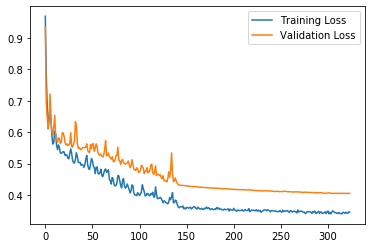

In [13]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']

plt.plot(train_loss, label='Training Loss')
plt.plot([i+0.1 for i in val_loss], label='Validation Loss')
plt.legend()

# The model has been trained, get predictions for the test set

### Predicted values

In [14]:
preds = model.predict(X_test)
predictions = pd.DataFrame(scaler.inverse_transform(preds), columns=df.columns, index=df.tail(len(X_test)).index)
predictions = predictions.drop('month', axis=1)
predictions.index = pd.MultiIndex.from_arrays([predictions.index.date, predictions.index.time], names=['Date','Time'])
predictions = predictions.unstack().reset_index().set_index('Date')
for col in predictions:
    predictions[col] = predictions[col].map('{:,.1f}'.format).astype(float)
predictions

visibility                                       dew_pt           \
Time         05:45:00 08:45:00 11:45:00 14:45:00 17:45:00 05:45:00 08:45:00   
Date                                                                          
2018-09-23        7.6      6.9      8.3      9.1      9.2     21.0     19.9   
2018-09-24        8.8      7.1      8.4      8.5      8.6     20.6     19.2   
2018-09-25        8.5      7.0      7.1      7.3      7.6     21.0     20.4   
2018-09-26        6.7      6.2      6.8      7.2      7.2     20.7     20.1   
2018-09-27        6.4      5.9      7.2      7.7      7.8     20.7     20.2   
...               ...      ...      ...      ...      ...      ...      ...   
2018-12-27        8.8      7.1      7.1      9.1      9.6     10.1      9.0   
2018-12-28        9.1      7.4      7.5      8.9      9.2      9.9      8.5   
2018-12-29        8.8      7.2      7.3      9.8     10.0      9.6      8.3   
2018-12-30        9.7      7.9      8.1     10.0     10.3      8.8      7.5   
2018-12-31       10.1      8.2      8.4     10.4     10.4      8.5      7.2   

                                       ...       RH                    \
Time       11:45:00 14:45:00 17:45:00  ... 05:45:00 08:45:00 11:45:00   
Date                                   ...                              
2018-09-23     20.7     20.4     20.4  ...     78.4     84.6     74.6   
2018-09-24     20.7     20.9     21.0  ...     71.7     85.0     74.0   
2018-09-25     20.7     20.9     21.1  ...     72.9     81.4     80.4   
2018-09-26     21.0     21.3     21.3  ...     82.9     87.2     81.7   
2018-09-27     21.1     21.5     21.6  ...     85.0     88.6     79.8   
...             ...      ...      ...  ...      ...      ...      ...   
2018-12-27      9.1     10.0      9.6  ...     66.3     90.6     90.6   
2018-12-28      8.7      9.8      9.5  ...     63.2     90.3     89.7   
2018-12-29      8.2      8.8      8.6  ...     65.3     90.8     90.8   
2018-12-30      7.4      8.4      8.0  ...     59.7     89.6     89.5   
2018-12-31      7.3      8.2      8.0  ...     57.1     89.3     88.5   

                                  WET                                      
Time       14:45:00 17:45:00 05:45:00 08:45:00 11:45:00 14:45:00 17:45:00  
Date                                                                       
2018-09-23     70.4     69.4     22.3     20.7     22.2     22.3     22.4  
2018-09-24     73.0     72.5     22.3     20.0     22.2     22.6     22.6  
2018-09-25     79.7     77.8     22.7     21.6     21.9     22.1     22.4  
2018-09-26     78.9     78.4     21.7     20.8     22.1     22.6     22.6  
2018-09-27     76.4     75.9     21.5     20.8     22.3     22.9     23.1  
...             ...      ...      ...      ...      ...      ...      ...  
2018-12-27     63.1     56.1     13.1      9.7      9.9     13.3     13.7  
2018-12-28     63.3     58.1     13.2      9.2      9.5     13.1     13.4  
2018-12-29     57.1     54.2     12.8      9.0      8.9     12.8     12.9  
2018-12-30     64.4     51.8     12.6      8.3      8.2     11.7     12.6  
2018-12-31     54.7     51.7     12.5      8.1      8.3     12.4     12.6  

[100 rows x 40 columns]

### Actual Values

In [15]:
actual = df.tail(len(X_test))
actual.index = pd.MultiIndex.from_arrays([actual.index.date, actual.index.time], names=['Date','Time'])
actual = actual.drop('month', axis=1)
actual = actual.unstack().reset_index().set_index('Date')
actual

visibility                                       dew_pt           \
Time         05:45:00 08:45:00 11:45:00 14:45:00 17:45:00 05:45:00 08:45:00   
Date                                                                          
2018-09-23        6.0      8.0     10.0     10.0      8.0     20.1     21.2   
2018-09-24        5.0      6.0     10.0     10.0      5.0     20.7     20.3   
2018-09-25        2.0      5.0      7.0      8.0      7.0     21.8     22.1   
2018-09-26        3.0      3.0      6.0      9.0      9.0     20.5     22.2   
2018-09-27        6.0      6.0      6.0     10.0     10.0     20.0     20.8   
...               ...      ...      ...      ...      ...      ...      ...   
2018-12-27        7.0     10.0     10.0     10.0     10.0      7.2      7.0   
2018-12-28        6.0      7.0      8.0     10.0     10.0      5.3      6.8   
2018-12-29        6.0     10.0     10.0     10.0     10.0      4.1      5.7   
2018-12-30        7.0     10.0     10.0     10.0     10.0      4.4      5.6   
2018-12-31        7.0     10.0     10.0     10.0     10.0      4.6      5.4   

                                       ...       RH                    \
Time       11:45:00 14:45:00 17:45:00  ... 05:45:00 08:45:00 11:45:00   
Date                                   ...                              
2018-09-23     22.0     22.3     22.0  ...     97.0     82.0     70.0   
2018-09-24     23.5     22.4     21.8  ...     89.0     78.0     70.0   
2018-09-25     22.8     23.0     23.0  ...     96.0     90.0     70.0   
2018-09-26     22.0     22.4     22.7  ...     90.0     91.0     75.0   
2018-09-27     22.5     22.0     21.9  ...     90.0     82.0     75.0   
...             ...      ...      ...  ...      ...      ...      ...   
2018-12-27      6.6      7.2      6.3  ...     94.0     88.0     53.0   
2018-12-28      7.3      6.8      8.6  ...     92.0     90.0     61.0   
2018-12-29      6.5      6.6      8.7  ...     89.0     86.0     55.0   
2018-12-30      6.6      6.4      9.3  ...     94.0     89.0     54.0   
2018-12-31      6.5      7.2      7.8  ...     95.0     84.0     53.0   

                                  WET                                      
Time       14:45:00 17:45:00 05:45:00 08:45:00 11:45:00 14:45:00 17:45:00  
Date                                                                       
2018-09-23     64.0     73.0     20.2     22.2     23.8     24.5     23.5  
2018-09-24     72.0     90.0     21.3     21.5     25.2     24.0     22.4  
2018-09-25     69.0     81.0     22.0     22.7     24.6     24.7     24.0  
2018-09-26     63.0     72.0     21.0     22.7     23.4     24.6     24.2  
2018-09-27     61.0     73.0     20.6     21.8     23.8     24.3     23.4  
...             ...      ...      ...      ...      ...      ...      ...  
2018-12-27     48.0     60.0      7.7      8.0     11.2     12.4      9.8  
2018-12-28     50.0     70.0      6.0      7.6     10.8     12.0     11.3  
2018-12-29     45.0     68.0      5.4      6.8     11.0     12.3     11.4  
2018-12-30     40.0     67.0      4.8      6.6     11.2     12.8     12.1  
2018-12-31     42.0     60.0      5.0      6.7     11.2     13.2     11.4  

[100 rows x 40 columns]

# Visualize the predictions

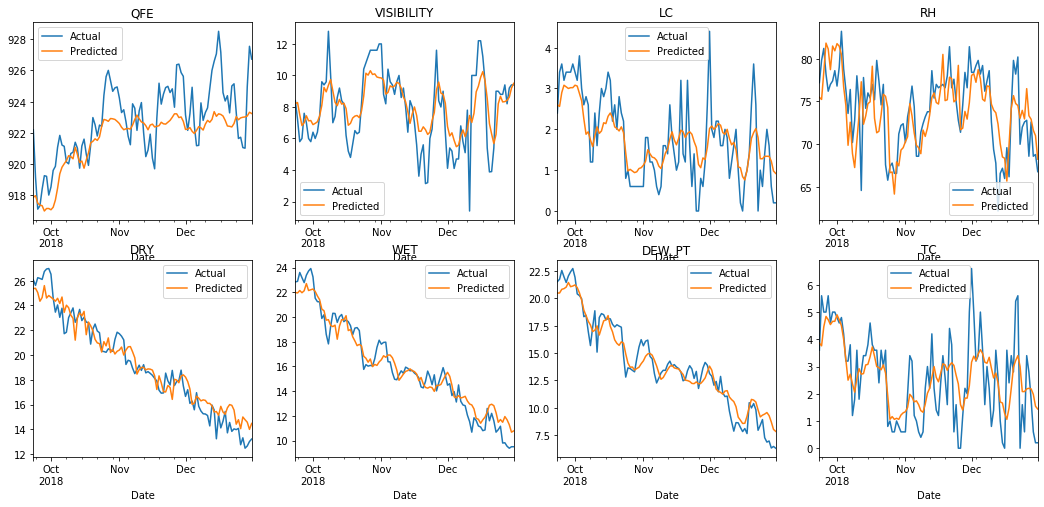

In [16]:
columns = list(set(actual.columns.get_level_values(0)))
columns
fig, ax_array = plt.subplots(2, 4, figsize=(18, 8))
for i in range(2):
    for j in range(4):
        title = columns[4*i+j]
        ax = actual[(title,)].mean(axis=1).plot(kind='line', ax=ax_array[i][j], title=title.upper())
        ax = predictions[(title,)].mean(axis=1).plot(kind='line', ax=ax_array[i][j], title=title.upper())
        ax.legend(['Actual', 'Predicted'])

# Actual Data Statistics

In [17]:
actual_df = actual.stack().reset_index().set_index('Date')
df = actual_df.resample('D')
actual_data_stats = df.mean().describe().iloc[1:,:]
actual_data_stats

,DRY,LC,QFE,RH,TC,WET,dew_pt,visibility
mean,19.204800,1.772000,922.79440,74.230000,2.61800,16.027000,14.035260,7.836800
std,3.917883,1.068188,2.40699,4.540936,1.65098,3.855346,4.267352,2.426067
min,12.480000,0.000000,917.12000,62.200000,0.00000,9.380000,6.300000,1.400000
25%,15.935000,0.950000,921.12500,71.350000,1.15000,13.165000,11.435000,6.000000
50%,18.770000,1.600000,922.87000,75.100000,2.70000,15.630000,13.580000,8.200000
75%,22.200000,2.600000,924.70000,77.650000,3.60000,19.110000,17.365000,9.450000
max,26.980000,4.400000,928.50000,83.200000,6.60000,23.920000,22.720000,12.800000


# Prediction Data Statistics

In [18]:
pred_df = predictions.stack().reset_index().set_index('Date')
df = pred_df.resample('D')
predicted_data_stats = df.mean().describe().iloc[1:,:]
predicted_data_stats

,DRY,LC,QFE,RH,TC,WET,dew_pt,visibility
mean,19.432400,1.752000,921.663400,73.887200,2.628200,16.103000,14.050800,8.026800
std,3.347598,0.587713,1.802633,3.869514,0.989819,3.297978,3.631055,1.274731
min,14.000000,0.760000,917.000000,64.180000,1.060000,10.680000,7.840000,5.480000
25%,16.370000,1.280000,920.990000,71.335000,1.840000,13.530000,11.515000,6.960000
50%,18.870000,1.780000,922.420000,74.090000,2.700000,15.620000,13.560000,8.140000
75%,22.060000,2.030000,922.845000,76.125000,3.160000,18.525000,16.715000,9.110000
max,25.600000,3.080000,923.360000,81.820000,4.900000,22.700000,21.440000,10.300000
